In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import wandb
import copy
import time
from datetime import datetime
from pytz import timezone
import seaborn as sns

import cv2

from torchvision.transforms import ToTensor,Compose,ColorJitter,RandomRotation,RandomHorizontalFlip,Resize,CenterCrop,Normalize,GaussianBlur,RandomCrop

import timm

import torch
import torch.nn as nn
import torch.optim as optm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import gridspec

from torchinfo import summary
from tqdm.auto import tqdm

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cwd=os.path.dirname(os.getcwd())
KST=timezone('Asia/Seoul')
date=str(datetime.now().astimezone(KST))[:10]

In [2]:
#프로젝트 이름 설정과 저장경로
project_name='AgeEfficientNet_with_confusion_matrix'


In [3]:
#Randomness 제어
random_seed=2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
transform={'trans':Compose([
    Resize((256*512//384,256)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
]),'regtrans':Compose([
    Resize((256*512//384,256)),
    GaussianBlur(3),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    RandomCrop(224),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
]),
'uptrans':Compose([
    Resize((256*512//384,256)),
    ColorJitter(brightness=0.25, contrast=0),
    RandomHorizontalFlip(),
    RandomRotation(20),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])}

def make_images(meta,img_dir,train):
    images=[]
    labels=[]
    data=pd.DataFrame({'images':[],'labels':[]})
    if train:
        for idx in range(len(meta)):
            folder_path=os.path.join(img_dir, meta.path.iloc[idx])
            for img in os.listdir(folder_path):
                if '._' in img:
                    continue
                images.append(Image.open(os.path.join(folder_path,img)))
                labels.append((('incorrect' in img)+('normal' in img)*2)*6+(meta.gender.iloc[idx]=='female')*3+(30<=meta.age.iloc[idx])+(60<=meta.age.iloc[idx]))
    else:
        for img_id in meta.ImageID:
            images.append(Image.open(os.path.join(img_dir, img_id)))
        labels=[0 for _ in range(len(images))]
    data['images']=images
    data['labels']=labels
    return data

class ImageDataset(Dataset):
    def __init__(self,transform=transform,mod='train'):
        self.mod=mod
        self.train=mod!='test'
        self.md=['info','train']
        self.path=[os.path.join(cwd,'input/data/eval'),os.path.join(cwd,'input/data/train')]
        self.meta=pd.read_csv(os.path.join(self.path[self.train], f'{self.md[self.train]}.csv'))
        self.img_dir=os.path.join(self.path[self.train],'images')
        self.classes=[('Wear','Incorrect','Not Wear'),('남','여'),('<30','>=30 and <60','>=60')]
        self.trans=transform
        self.criteria=1*(self.meta['age']>=30)+1*(self.meta['age']>=60)+3*(self.meta['gender']=='female')
        if self.train:
            self.train_data,self.val_data=train_test_split(self.meta,test_size=0.2,stratify=self.criteria)
            self.train_data=make_images(self.train_data,self.img_dir,self.train)
            self.val_data=make_images(self.val_data,self.img_dir,self.train)
    
    def __len__(self):
        return len(self.train_data) if self.mod=='train' else len(self.val_data)
        
    
    def __getitem__(self, idx):
        if self.mod=='valid':
            images=self.val_data['images']
            labels=self.val_data['labels']
        elif self.mod=='train':
            images=self.train_data['images']
            labels=self.train_data['labels']

        label=labels.iloc[idx]
        image=images.iloc[idx]
        
        if self.mod=='train':
            if label%3==2:
                image=self.trans['uptrans'](image)
                return image,label
            else:
                image=self.trans['regtrans'](image)
        else:
            image=self.trans['trans'](image)
        return image,label

def conf_mat(y_true,y_pred):
    cm=confusion_matrix(y_true,y_pred)
    norm_cm=cm/np.sum(cm, axis=1)[:,None]
    cm=pd.DataFrame(norm_cm,index=['mask<30','mask<>','mask60','inc<30','inc<>','inc60','nom<30','nom<>','nom60'],columns=['mask<30','mask45','mask60','inc<30','inc<>','inc60','nom<30','nom<>','nom60'])
    fig=plt.figure(figsize=(18,16))
    sns.heatmap(cm,annot=True)
    return fig


# 부분 모델 학습과 모델저장

In [5]:
#사용할 부분 모델 불러오기
net_mask = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=3)
net_gender = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=2)
net_age = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=3)

In [6]:
#학습 설정하기
num_epochs=1000
batch_size=60
learning_rate=0.001
loss_fn=nn.CrossEntropyLoss()
models={'mask':net_mask,'gender':net_gender,'age':net_age}
classes_num=torch.tensor([6405/12, 6135/30, 960, 1281/12, 1227/30, 192, 1281/12, 1227/30, 192])
weight=(torch.tensor([2100. for _ in range(9)])/classes_num).to(device)
config={'epochs':num_epochs,'batch_size':batch_size,'learning_rate':learning_rate}

wandb: Currently logged in as: tentoto (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



training: age
mod: train



현재 epoch-0의 평균 Loss : 0.266, 평균 Accuracy : 0.914, F1 score : 0.897
mod: valid



현재 epoch-0의 평균 Loss : 0.516, 평균 Accuracy : 0.885, F1 score : 0.683


AttributeError: 'int' object has no attribute 'zfill'

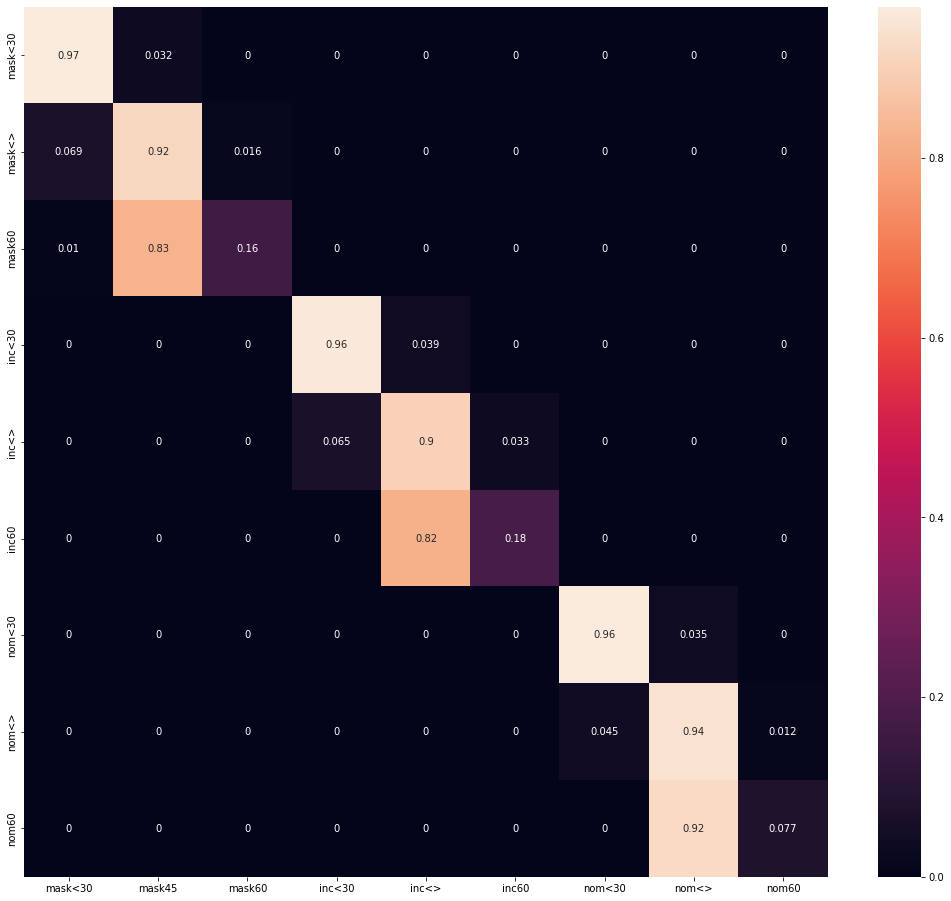

In [7]:
#실행 파일 저장 경로
now='Runned'+'_'.join(str(datetime.now().astimezone(KST))[10:16].split(':'))
base_dir=os.path.join('.',f'saved/{project_name}/{date}/{now}')
wandb_dir=base_dir
checkpoint_dir=''
model_dir=''
result_dir=''
dirs={'model':model_dir,'checkpoint':checkpoint_dir,'result':result_dir}
for pth in ['model','checkpoint','result']:
    dirs[pth]=os.path.join(base_dir,pth)
    if not os.path.isdir(dirs[pth]):
        os.makedirs(dirs[pth])

#부분 모델 사전 학습
for key in ['age']:
    data=ImageDataset()
    wandb.init(project=project_name+'_'+key+'_'+date,config=config,dir=wandb_dir)
    print('training:',key)
    model=models[key]
    model.to(device)
    optim=optm.Adam(model.parameters())
    scheduler = optm.lr_scheduler.StepLR(optim, step_size=1, gamma=0.75)
    loss_fn=nn.CrossEntropyLoss(weight=weight)
    best_f1=0.
    stopper=0
    for e in range(num_epochs):   
        for mod in ['train','valid']:
            print('mod:',mod)
            data.mod=mod

            if mod=='train':
                dataloader=DataLoader(data,batch_size=batch_size,shuffle=True)
                model.train()
            else:
                dataloader=DataLoader(data,shuffle=False)
                model.eval()

            with tqdm(dataloader) as pbar:
                running_loss=0.
                running_acc=0.
                tot_pred=torch.tensor([]).to(device)
                tot_label=torch.tensor([]).to(device)
                cm_pred=torch.tensor([]).to(device)
                cm_label=torch.tensor([]).to(device)
                for n,(image,label) in enumerate(pbar):
                    image=image.to(device)
                    label=label.to(device)
                    classes={'mask':label//6,'gender':(label//3)%2,'age':label%3}
                    class_ind=classes['mask']
                    label=classes[key]+3*class_ind
                    
                    logit=model(image).view(image.size(0),1,3)
                    class_sep=torch.tensor([[i==ind for i in range(3)] for ind in class_ind]).to(device)
                    logit=(class_sep.view(image.size(0),3,1)*logit).view(image.size(0),-1)
                    _,pred=torch.max(logit,1)
                    
                    if data.train:
                        loss=loss_fn(logit,label)
                        running_loss+=loss.item()*image.size(0)
                        running_acc+=torch.sum(pred==label)/image.size(0)
                        
                    if mod=='train':
                        optim.zero_grad()
                        loss.backward()
                        optim.step()
                        
                    tot_pred=torch.hstack((tot_pred,pred))
                    tot_label=torch.hstack((tot_label,label))
                    cm_pred=torch.hstack((cm_pred,pred))
                    cm_label=torch.hstack((cm_label,label))
                    if data.train:
                        pbar.set_postfix({'epoch' : e, 'loss' : running_loss/(n+1), 'accuracy' : float(running_acc)/(n+1),'F1 score':f1_score(tot_label.cpu(),tot_pred.cpu(),average='macro')})
                        if mod=='train':
                            wandb.log({f'running loss {e}' : running_loss/(n+1), f'running accuracy {e}' : float(running_acc)/(n+1),f'running f1 score {e}':f1_score(tot_label.cpu(),tot_pred.cpu(),average='macro')})
                if data.train:
                    epoch_loss=running_loss/len(dataloader.dataset)
                    epoch_acc=running_acc*image.size(0)/len(dataloader.dataset)
                    epoch_f1=f1_score(tot_label.cpu(),tot_pred.cpu(),average='macro')
                    print(f"현재 epoch-{e}의 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, F1 score : {epoch_f1:.3f}")
        if mod=='valid':
            cm=conf_mat(cm_label.cpu(),cm_pred.cpu())
            cm.savefig(f'./saved/{project_name}/{date}/{now}/checkpoint/checkpoint_{key}_{e}.jpg')
            wandb.log({f'confusion_matrix_{e}':wandb.Image(cm),'loss' : epoch_loss, 'accuracy' : epoch_acc,'f1 score':f1_score(tot_label.cpu(),tot_pred.cpu(),average='macro')})
            if best_f1<epoch_f1:
                stopper=0
                best_f1=epoch_f1
                torch.save({'epoch':e,'loss':loss,'model_state_dict':model.state_dict(),'optimizer_state_dict':optim.state_dict()},f"{dirs['checkpoint']}/checkpoint_{key}_{str(e).zfill(3)}_{epoch_loss:.3f}_{epoch_acc:.3f}_{epoch_f1:.3f}.pt")
            elif stopper==10:
                break
            else:
                stopper+=1
    wandb.finish()